# Challenge Problem 1 — 2.156 Artificial Intelligence and Machine Learning for Engineering Design (MIT, Fall 2025)

**Multiobjective optimization via NSGA-II and Gradient Descent

Outline:
1. Setup
a. Environment Setup
b. Load target curves
c. Compile optimization tools & define the mixed‑variable problem

2. Generate initial mechanisms population
2.a. Randomize mechanisms
2.b. Hypervolume Evaluation

3. GA refinement
3.a. Hypervolume Evaluation
3.b. Hypervolume Evaluation

4. GD Refinement
4.a. Gradient Descent Optimization
4.b. Hypervolume Evaluation

5. Evaluation & Merging
5.a. Compare results to previous run
5.b. Save Best Results

## 1) Setup
1.a. Envirnoment Setup

In [ ]:
# === Advanced Notebook — Cell 0 ===
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deterministic random numbers
np.random.seed(0)
random.seed(0)


## 2) Load target curves


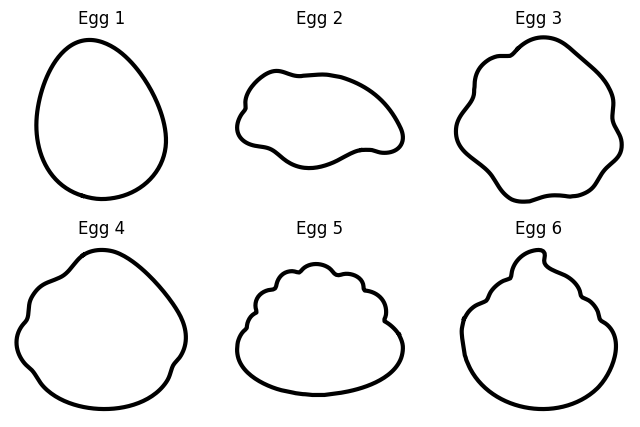

In [3]:
# === Advanced Notebook — Cell 2 ===
target_curves = np.load('target_curves.npy')

# Plot all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))
for i in range(6):
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')
plt.show()


## 3) Imports for optimization (pymoo, LINKS Tools)


In [4]:
# === Advanced Notebook — Cell 4 ===
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools


## 4) Compile Tools and define the mixed-variable mechanism problem


In [5]:
# === Advanced Notebook — Cell 5 (first lines) ===
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs


In [6]:
# === Advanced Notebook — Cell 5 (class) ===
class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


## 5) Mechanism randomizer and visualizer (for population init)


In [7]:
# === Advanced Notebook — Cell 10 ===
from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer


In [8]:
# === Advanced Notebook — Cell 11 ===
randomizer = MechanismRandomizer(
    min_size = 6, # smallest mechanism to sample
    max_size = 14, # largest mechanism to sample
    device='cpu')

visualizer = MechanismVisualizer()


## 6) NSGA‑II per target curve (random seeding) and saving results


In [9]:
# === Advanced Notebook — Cells 14–16 (wrapped per target curve) ===

import os

os.makedirs("ga_outputs", exist_ok=True)

for target_idx in range(6):
    print(f"\n===== Optimizing for Target Curve {target_idx+1} / 6 =====")
    target_curve = target_curves[target_idx]

    # --- Advanced Cell 14: generate mechanisms (size fixed at 7 here, per the example) ---
    mechanisms = [randomizer(n=7) for _ in trange(100)]

    # --- Advanced Cell 15: instantiate problem, convert batch to 1D, define sampling, evaluate initial F ---
    problem = mechanism_synthesis_optimization(target_curve, N=7)

    initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

    class sample_from_random(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            return np.array([initial_population[i % len(initial_population)] for i in range(n_samples)])

    F = problem.evaluate(np.array(initial_population))[0]
    print(f'Best Distance Performance In random population: {F[:,0].min()}')
    print(f'Best Material Performance In random population: {F[:,1].min()}')

    # --- Advanced Cell 16: NSGA-II with mixed-variable mating and polynomial mutation ---
    algorithm = NSGA2(
        pop_size=100,
        sampling=sample_from_random(),
        mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
        mutation=PolynomialMutation(prob=0.5),
        eliminate_duplicates=MixedVariableDuplicateElimination()
    )

    results = minimize(
        problem,
        algorithm,
        ('n_gen', 100),
        verbose=True,
        save_history=True,
        seed=123
    )

    # === Save raw GA results (pickled by numpy) ===
    # results.X is typically an array of dictionaries (mixed variables); results.F is the objective array.
    np.save(f"ga_outputs/results_curve_{target_idx}_X.npy", results.X, allow_pickle=True)
    np.save(f"ga_outputs/results_curve_{target_idx}_F.npy", results.F, allow_pickle=True)

    # === Convert each GA solution to mechanism representation and save as a list of dicts ===
    converted = []
    if results.X is not None:
        for x in results.X:
            try:
                x0, edges, fixed_joints, motor, target_node = problem.convert_1D_to_mech(x)
                converted.append({
                    "x0": x0,
                    "edges": edges,
                    "fixed_joints": fixed_joints,
                    "motor": motor,
                    "target": int(target_node)
                })
            except Exception as e:
                # Skip any entries that fail conversion
                pass

    np.save(f"ga_outputs/mechanisms_curve_{target_idx}.npy", np.array(converted, dtype=object), allow_pickle=True)

print("\nAll curves processed. Results saved under ./ga_outputs/")



===== Optimizing for Target Curve 1 / 6 =====


  0%|          | 0/100 [00:00<?, ?it/s]

Best Distance Performance In random population: 0.9280715584754944
Best Material Performance In random population: 5.041465759277344
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.5068932772 |  9.2709438509 |             - |             -
     2 |      200 |      1 |  0.5068932772 |  7.8342225546 |             - |             -
     3 |      300 |      1 |  0.1156975031 |  6.8262598604 |             - |             -
     4 |      400 |      1 |  0.1156975031 |  6.1923727125 |             - |             -
     5 |      500 |      1 |  0.1156975031 |  5.4886444896 |             - |             -
     6 |      600 |      1 |  0.1156975031 |  4.9672359318 |             - |             -
     7 |      700 |      1 |  0.1156975031 |  4.6426139516 |             - |             -
     8 |      800 |      1 |  0.1156975031 |  4.2729680580 |             - |             -
     9 |      900 |      1 |  0.1156975031 |  3.

  0%|          | 0/100 [00:00<?, ?it/s]

Best Distance Performance In random population: 0.953870415687561
Best Material Performance In random population: 4.925920486450195
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.4313849211 |  8.3674822187 |             - |             -
     2 |      200 |      1 |  0.4313849211 |  7.5729045749 |             - |             -
     3 |      300 |      1 |  0.4313849211 |  6.5385264301 |             - |             -
     4 |      400 |      1 |  0.4313849211 |  6.0723182511 |             - |             -
     5 |      500 |      1 |  0.4313849211 |  5.3169683480 |             - |             -
     6 |      600 |      1 |  0.4313849211 |  5.1029308629 |             - |             -
     7 |      700 |      1 |  0.4313849211 |  4.7298292816 |             - |             -
     8 |      800 |      1 |  0.4313849211 |  4.3479866850 |             - |             -
     9 |      900 |      1 |  0.4313849211 |  3.8

  0%|          | 0/100 [00:00<?, ?it/s]

Best Distance Performance In random population: 0.4471595585346222
Best Material Performance In random population: 4.423672199249268
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.5747004747 |  8.5585620868 |             - |             -
     2 |      200 |      1 |  0.5747004747 |  8.3007780755 |             - |             -
     3 |      300 |      1 |  0.5747004747 |  7.2170657897 |             - |             -
     4 |      400 |      1 |  0.5747004747 |  6.5076590776 |             - |             -
     5 |      500 |      1 |  0.5747004747 |  6.0108895338 |             - |             -
     6 |      600 |      1 |  0.000000E+00 |  5.0362957966 |             - |             -
     7 |      700 |      1 |  0.000000E+00 |  4.6864735496 |  0.000000E+00 |             f
     8 |      800 |      1 |  0.000000E+00 |  4.6149203241 |  0.000000E+00 |             f
     9 |      900 |      1 |  0.000000E+00 |  4.

  0%|          | 0/100 [00:00<?, ?it/s]

Best Distance Performance In random population: 0.7239013314247131
Best Material Performance In random population: 6.12076997756958
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.2680225372 |  8.5411058867 |             - |             -
     2 |      200 |      1 |  0.2680225372 |  7.6598129165 |             - |             -
     3 |      300 |      1 |  0.2680225372 |  6.2013014686 |             - |             -
     4 |      400 |      1 |  0.2680225372 |  5.6122891939 |             - |             -
     5 |      500 |      1 |  0.2680225372 |  4.9983037722 |             - |             -
     6 |      600 |      1 |  0.2680225372 |  4.6553096426 |             - |             -
     7 |      700 |      1 |  0.2680225372 |  4.4886882579 |             - |             -
     8 |      800 |      1 |  0.2680225372 |  4.3135817730 |             - |             -
     9 |      900 |      1 |  0.2680225372 |  4.2

  0%|          | 0/100 [00:00<?, ?it/s]

Best Distance Performance In random population: 0.8761928081512451
Best Material Performance In random population: 4.33170223236084
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.1261928082 |  8.4464739770 |             - |             -
     2 |      200 |      1 |  0.1261928082 |  7.9953681248 |             - |             -
     3 |      300 |      1 |  0.1261928082 |  7.4099788588 |             - |             -
     4 |      400 |      1 |  0.1261928082 |  6.6367153949 |             - |             -
     5 |      500 |      1 |  0.1261928082 |  5.5226287740 |             - |             -
     6 |      600 |      1 |  0.1261928082 |  4.8075143856 |             - |             -
     7 |      700 |      1 |  0.1261928082 |  4.5362403077 |             - |             -
     8 |      800 |      1 |  0.1261928082 |  4.1064007944 |             - |             -
     9 |      900 |      1 |  0.1261928082 |  4.0

  0%|          | 0/100 [00:00<?, ?it/s]

Best Distance Performance In random population: 0.5641698241233826
Best Material Performance In random population: 5.5040788650512695
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.000000E+00 |  8.5318651593 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |  7.8905631578 |  0.000000E+00 |             f
     3 |      300 |      1 |  0.000000E+00 |  6.9545135295 |  0.000000E+00 |             f
     4 |      400 |      1 |  0.000000E+00 |  6.0449823678 |  0.000000E+00 |             f
     5 |      500 |      1 |  0.000000E+00 |  5.7012053311 |  0.000000E+00 |             f
     6 |      600 |      1 |  0.000000E+00 |  5.1357477725 |  0.000000E+00 |             f
     7 |      700 |      1 |  0.000000E+00 |  4.5228863299 |  0.000000E+00 |             f
     8 |      800 |      1 |  0.000000E+00 |  4.3022703469 |  0.000000E+00 |             f
     9 |      900 |      1 |  0.000000E+00 |  4